[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Module 2b: Playing with pytorch: linear regression

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=960)

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import torch
import numpy as np
from tqdm import tqdm

In [2]:
torch.__version__

'2.0.0'

## Warm-up: Linear regression with numpy

Our model is:
$$
y_t = 2x^1_t-3x^2_t+1, \quad t\in\{1,\dots,30\}
$$

Our task is given the 'observations' $(x_t,y_t)_{t\in\{1,\dots,30\}}$ to recover the weights $w^1=2, w^2=-3$ and the bias $b = 1$.

In order to do so, we will solve the following optimization problem:
$$
\underset{w^1,w^2,b}{\operatorname{argmin}} \sum_{t=1}^{30} \left(w^1x^1_t+w^2x^2_t+b-y_t\right)^2
$$

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=1080)

In [3]:
import numpy as np
import pandas as pd
from numpy.random import random
# generate random input data
x = random((30,2))

# generate labels corresponding to input data x
y = np.dot(x, [2., -3.]) + 1.
w_source = np.array([2., -3.])
b_source  = np.array([1.])

In [4]:
df = pd.DataFrame(np.array([x[:, 0], x[:, 1], y]).T, columns=['x1', 'x2', 'y'])
fig = px.scatter_3d(df, x='x1', y='x2', z='y')

fig.update_layout(scene = dict(
                        xaxis=dict(
                            nticks=10, range=[0, 1]
                            ), 
                        yaxis=dict(
                            nticks=10, range=[0, 1]
                            ),
                        )
                  )
fig.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D

def plot_figs(fig_num, elev, azim, x, y, weights, bias):
    fig = plt.figure(fig_num, figsize=(6, 6))
    plt.clf()
    #ax = Axes3D(fig, elev=elev, azim=azim)
    ax = fig.add_subplot(projection='3d', elev=elev, azim=azim)
    ax.scatter(x[:, 0], x[:, 1], y)
    ax.plot_surface(np.array([[0, 0], [1, 1]]),
                    np.array([[0, 1], [0, 1]]),
                    (np.dot(np.array([[0, 0, 1, 1],
                                          [0, 1, 0, 1]]).T, weights) + bias).reshape((2, 2)),
                    alpha=.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    
def plot_views(x, y, w, b):
    #Generate the different figures from different views
    elev = 43.5
    azim = -110
    plot_figs(1, elev, azim, x, y, w, b[0])

    plt.show()

/var/folders/vv/mm_j1lh17m79th1f4htvv0480000gn/T/ipykernel_78731/2100076528.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



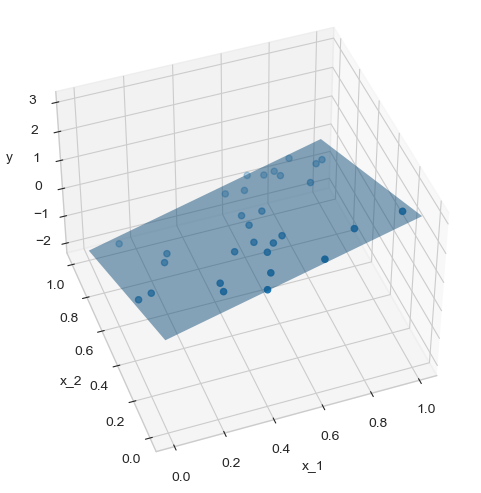

In [6]:
plt.style.use('seaborn-whitegrid')
plot_views(x, y, w_source, b_source)

In vector form, we define:
$$
\hat{y}_t = {\bf w}^T{\bf x}_t+b
$$
and we want to minimize the loss given by:
$$
loss = \sum_t\underbrace{\left(\hat{y}_t-y_t \right)^2}_{loss_t}.
$$

To minimize the loss we first compute the gradient of each $loss_t$:
$$
\frac{\partial{loss_t}}{\partial w^1} = 2x^1_t\left({\bf w}^T{\bf x}_t+b-y_t \right)\\
\frac{\partial{loss_t}}{\partial w^2} = 2x^2_t\left({\bf w}^T{\bf x}_t+b-y_t \right)\\
\frac{\partial{loss_t}}{\partial b} = 2\left({\bf w}^T{\bf x}_t+b-y_t \right)
$$

Note that the actual gradient of the loss is given by:
$$
\frac{\partial{loss}}{\partial w^1} =\sum_t \frac{\partial{loss_t}}{\partial w^1},\quad
\frac{\partial{loss}}{\partial w^2} =\sum_t \frac{\partial{loss_t}}{\partial w^2},\quad
\frac{\partial{loss}}{\partial b} =\sum_t \frac{\partial{loss_t}}{\partial b}
$$

For one epoch, **(Batch) Gradient Descent** updates the weights and bias as follows:
$$
w^1_{new} = w^1_{old}-\alpha\frac{\partial{loss}}{\partial w^1} \\
w^2_{new} = w^2_{old}-\alpha\frac{\partial{loss}}{\partial w^2} \\
b_{new} = b_{old}-\alpha\frac{\partial{loss}}{\partial b},
$$

and then we run several epochs.

In [7]:
# randomly initialize learnable weights and bias
w_init = random(2)
b_init = random(1)

w = w_init
b = b_init
print("initial values of the parameters:", w, b )

initial values of the parameters: [0.11080108 0.18629255] [0.46002118]


In [8]:
# our model forward pass
def forward(x):
    return x.dot(w)+b

# Loss function
def loss(x, y):
    y_pred = forward(x)
    return (y_pred - y)**2 

print("initial loss:", np.sum([loss(x_val,y_val) for x_val, y_val in zip(x, y)]) )

# compute gradient
def gradient(x, y):  # d_loss/d_w, d_loss/d_c
    return 2 * (x.dot(w)+b - y) * x, 2 * (x.dot(w)+b - y)

# shouldn't you like normalize the data first lol?
learning_rate = 1e-2

# Training loop
for epoch in tqdm(range(100)):
    grad_w = np.array([0,0])
    grad_b = np.array(0)
    l = 0
    for x_val, y_val in zip(x, y):
        grad_w = np.add(grad_w, gradient(x_val, y_val)[0])
        grad_b = np.add(grad_b, gradient(x_val, y_val)[1])
        l += loss(x_val, y_val)
    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b
    if (epoch%10 == 0):
        print("progress:", "epoch:", epoch, "loss",l[0])

# After training
print("estimation of the parameters:", w, b)

initial loss: 30.107415624181407


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1525.74it/s]

progress: epoch: 0 loss 30.10741562418141
progress: epoch: 10 loss 12.229494133248858
progress: epoch: 20 loss 5.317834437614493
progress: epoch: 30 loss 2.3595063651601937
progress: epoch: 40 loss 1.0707304357511565
progress: epoch: 50 loss 0.49769814101616866
progress: epoch: 60 loss 0.237061486176843
progress: epoch: 70 loss 0.11562235762134639
progress: epoch: 80 loss 0.057641940571503375
progress: epoch: 90 loss 0.02929980146050521
estimation of the parameters: [ 1.91452621 -2.95831607] [1.02483075]


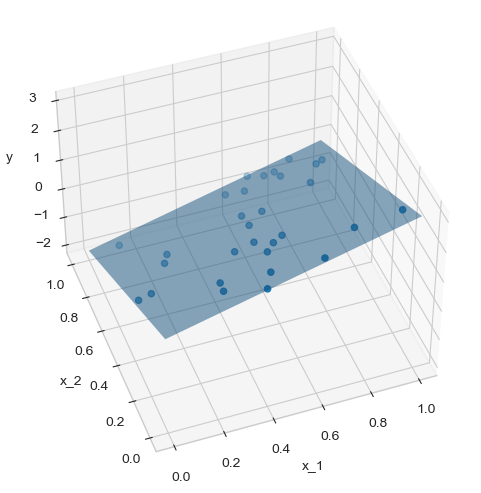

In [9]:
plot_views(x, y, w, b)  # Looks ligid compared with the actual plane ()

## Linear regression with tensors

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=1650)

In [10]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [11]:
x_t = torch.from_numpy(x).type(dtype)
y_t = torch.from_numpy(y).type(dtype).unsqueeze(1)

In [12]:
display(torch.from_numpy(y).type(dtype)[:5])
display(y_t[:5])

tensor([-0.1467,  0.3663, -0.6169, -1.5775,  1.0899])

tensor([[-0.1467],
        [ 0.3663],
        [-0.6169],
        [-1.5775],
        [ 1.0899]])

This is an implementation of **(Batch) Gradient Descent** with tensors.

Note that in the main loop, the functions loss_t and gradient_t are always called with the same inputs: they can easily be incorporated into the loop (we'll do that below).

In [13]:
w_init_t = torch.from_numpy(w_init).type(dtype)
b_init_t = torch.from_numpy(b_init).type(dtype)

w_t = w_init_t.clone()
w_t.unsqueeze_(1)
b_t = b_init_t.clone()
b_t.unsqueeze_(1)
print("initial values of the parameters:", w_t, b_t )

initial values of the parameters: tensor([[0.1108],
        [0.1863]]) tensor([[0.4600]])


In [15]:
# our model forward pass
def forward_t(x):
    return x.mm(w_t)+b_t

# Loss function
def loss_t(x, y):
    y_pred = forward_t(x)
    return (y_pred - y).pow(2).sum()

# compute gradient
def gradient_t(x, y):  # d_loss/d_w, d_loss/d_c
    # torch.mm performes matrix multiplication
    return 2*torch.mm(torch.t(x), x.mm(w_t) + b_t - y), 2 * (x.mm(w_t)+b_t - y).sum()

learning_rate = 1e-2
for epoch in tqdm(range(100)):
    l_t = loss_t(x_t,y_t)
    grad_w, grad_b = gradient_t(x_t,y_t)
    w_t = w_t-learning_rate*grad_w
    b_t = b_t-learning_rate*grad_b
    if (epoch%10 == 0):
        print("progress:", "epoch:", epoch, "loss",l_t)

# After training
print("estimation of the parameters:", w_t, b_t )

100%|██████████| 100/100 [00:00<00:00, 13783.90it/s]

progress: epoch: 0 loss tensor(12.2295)
progress: epoch: 10 loss tensor(5.3178)
progress: epoch: 20 loss tensor(2.3595)
progress: epoch: 30 loss tensor(1.0707)
progress: epoch: 40 loss tensor(0.4977)
progress: epoch: 50 loss tensor(0.2371)
progress: epoch: 60 loss tensor(0.1156)
progress: epoch: 70 loss tensor(0.0576)
progress: epoch: 80 loss tensor(0.0293)
progress: epoch: 90 loss tensor(0.0151)
estimation of the parameters: tensor([[ 1.9370],
        [-2.9723]]) tensor([[1.0200]])


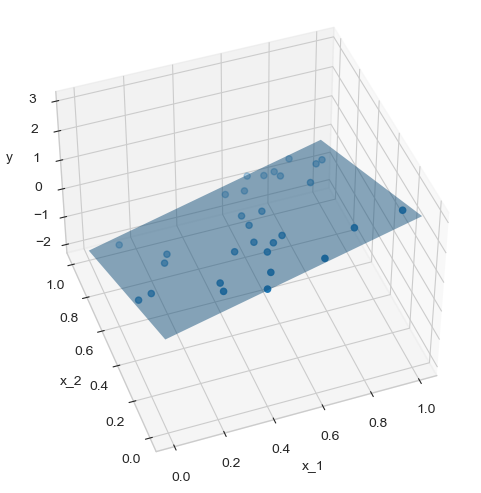

In [18]:
plot_views(x, y, w_t.numpy(), b_t.numpy())

## Linear regression with Autograd

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=1890)

In [19]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w_v = w_init_t.clone().unsqueeze(1)
w_v.requires_grad_(True)
b_v = b_init_t.clone().unsqueeze(1)
b_v.requires_grad_(True)
print("initial values of the parameters:", w_v.data, b_v.data )

initial values of the parameters: tensor([[0.1108],
        [0.1863]]) tensor([[0.4600]])


An implementation of **(Batch) Gradient Descent** without computing explicitly the gradient and using autograd instead.

In [ ]:
for epoch in range(10):
    y_pred = x_t.mm(w_v)+b_v
    loss = (y_pred - y_t).pow(2).sum()
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Variables with requires_grad=True.
    # After this call w.grad and b.grad will be tensors holding the gradient
    # of the loss with respect to w and b respectively.
    loss.backward()
    
    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w_v and b_v in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w_v -= learning_rate * w_v.grad
        b_v -= learning_rate * b_v.grad
    
    # Manually zero the gradients after updating weights
    # otherwise gradients will be acumulated after each .backward()
    w_v.grad.zero_()
    b_v.grad.zero_()
    
    print("progress:", "epoch:", epoch, "loss",loss.data.item())

# After training
print("estimation of the parameters:", w_v.data, b_v.data.t() )

## Linear regression with neural network

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=2075)

An implementation of **(Batch) Gradient Descent** using the nn package. Here we have a super simple model with only one layer and no activation function!

In [ ]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
)

for m in model.children():
    m.weight.data = w_init_t.clone().unsqueeze(0)
    m.bias.data = b_init_t.clone()

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

# switch to train mode
model.train()

for epoch in range(10):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Variable of input data to the Module and it produces
    # a Variable of output data.
    y_pred = model(x_t)
  
    # Note this operation is equivalent to: pred = model.forward(x_v)

    # Compute and print loss. We pass Variables containing the predicted and true
    # values of y, and the loss function returns a Variable containing the
    # loss.
    loss = loss_fn(y_pred, y_t)

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Variables with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad
        
    print("progress:", "epoch:", epoch, "loss",loss.data.item())

# After training
print("estimation of the parameters:")
for param in model.parameters():
    print(param)

Last step, we use directly the optim package to update the weights and bias.

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=2390)

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
)

for m in model.children():
    m.weight.data = w_init_t.clone().unsqueeze(0)
    m.bias.data = b_init_t.clone()

loss_fn = torch.nn.MSELoss(reduction='sum')

model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(10):
    y_pred = model(x_t)
    loss = loss_fn(y_pred, y_t)
    print("progress:", "epoch:", epoch, "loss",loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
# After training
print("estimation of the parameters:")
for param in model.parameters():
    print(param)

## Remark

This problem can be solved in 3 lines of code!

In [ ]:
xb_t = torch.cat((x_t,torch.ones(30).unsqueeze(1)),1)
# for old version of pytorch
#sol, _ =torch.lstsq(y_t,xb_t)
#sol[:3]
# for pytorch 1.9 and newer
sol = torch.linalg.lstsq(xb_t,y_t)
sol.solution

## Exercise: Play with the code

Change the number of samples from 30 to 300. What happens? How to correct it?

In [ ]:
x = random((300,2))
y = np.dot(x, [2., -3.]) + 1.
x_t = torch.from_numpy(x).type(dtype)
y_t = torch.from_numpy(y).type(dtype).unsqueeze(1)

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
)

for m in model.children():
    m.weight.data = w_init_t.clone().unsqueeze(0)
    m.bias.data = b_init_t.clone()

loss_fn = torch.nn.MSELoss(reduction = 'sum')

model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(10):
    y_pred = model(x_t)
    loss = loss_fn(y_pred, y_t)
    print("progress:", "epoch:", epoch, "loss",loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
# After training
print("estimation of the parameters:")
for param in model.parameters():
    print(param)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)